#Import

In [1]:
pip install pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.0/727.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 59.7 MB/s eta 0:00:00


In [2]:
!rm -r DL_Project
!git clone https://github.com/stefanoiervese/DL_Project
%cd DL_Project
!unzip Arithmetic.zip -d arithmetic_directory

rm: cannot remove 'DL_Project': No such file or directory
Cloning into 'DL_Project'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 75 (delta 30), reused 7 (delta 1), pack-reused 0
Receiving objects: 100% (75/75), 39.89 MiB | 11.72 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/DL_Project
Archive:  Arithmetic.zip
  inflating: arithmetic_directory/Arithmetic/arithmetic__add_or_sub.txt  
  inflating: arithmetic_directory/Arithmetic/arithmetic__div.txt  
  inflating: arithmetic_directory/Arithmetic/arithmetic__mul.txt  


In [3]:
import pytorch_lightning as pl
import os
import random
import re
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_sequence, pad_sequence


# Utilities

In [19]:
class Tokenizer:
    def __init__(self,sentences):
        self.sentences=sentences
        self.vocab = self.crea_vocabolario(sentences)
        self.word_to_id = {word: idx for idx, word in enumerate(self.vocab)}

    def tokenize(self, text):
        txt = re.sub(r'(\d+)', lambda x: ' '.join(list(x.group(1))), text)
        tokens = re.findall(r'\b\w+\b|\d+|[^\w\s]', txt)



        token_id = []
        unknown_tokens = []

        new_tokens = []
        for token in tokens:
          flag=0
          if '.' in token and token != '.':
            token=token=token.split('.')[0]
            flag=1
          if token in self.word_to_id:
            token_id.append(self.word_to_id[token])
          else:
                token_id.append(self.word_to_id['unknown'])
                unknown_tokens.append(token)
          if(flag==1):
            token_id.append(self.word_to_id['.'])


        if unknown_tokens:

          print("Parole sconosciute:", unknown_tokens)

        return token_id

    def crea_vocabolario(self, frasi):
      vocabolario = set()

      for frase in frasi:
        txt = re.sub(r'(\d+)', lambda x: ' '.join(list(x.group(1))), frase.lower())
        parole = re.findall(r'\b\w+\b|\d+|[^\w\s]', txt)
        vocabolario.update(parole)
      return ['&','#','@','unknown']+list(vocabolario)

def paper_accuracy(predicted_answers, correct_answers):
  num_correct_answers = 0
  end_of_line=2

  for i in range(len(predicted_answers)):

    single_predicted_answer = torch.argmax(predicted_answers[i], 1).tolist()  # vector of shape (answer_max_length) (concatenates the max value for each row)
    index = single_predicted_answer.index(2) if 2 in single_predicted_answer else len(single_predicted_answer) -1
    single_predicted_answer = single_predicted_answer[1:index]  # removing start and end of line char and additional characters
    single_correct_answer = correct_answers[i].tolist()
    single_correct_answer = single_correct_answer[1:single_correct_answer.index(2)]  # removing start of line, end of line and following characters

    if (single_predicted_answer == single_correct_answer):
      num_correct_answers += 1

  return num_correct_answers/len(predicted_answers)


def translate(phrase, vocab):
    text = ""
    for element in phrase:
        text += vocab[element.item()]
    return text
def translate_from_output(phrase, vocab):
    phrase = torch.argmax(F.softmax(phrase , dim = -1), dim = -1)
    text = ""
    for element in phrase:
        text += vocab[element.item()]
    return text




# Dataset preprocessing

In [5]:
path='./arithmetic_directory/Arithmetic/'
data_list=[]
for file in os.listdir(path):

  with open(path+file, "r") as file:
    content = file.read()
    data_list=data_list+[x for x in content.split('\n')]

while '' in data_list:
    data_list.remove('')

len_data=len(data_list)
quest=[]
ans=[]
for i in range(len_data):
  if(i%2==0):
    quest.append(data_list[i])
  else:
    data= data_list[i] + " @"
    ans.append(data)
coppie = list(zip(quest,ans))
random.shuffle(coppie)
quest, ans=zip(*coppie)
l=int(len(quest)/3)
train_q=quest[:2*l]
test_q=quest[2*l:]
train_a=ans[:2*l]
test_a=ans[2*l:]


tokenizer = Tokenizer(data_list)

qt=[]
at=[]
for x in train_q:
  qt.append(torch.tensor(tokenizer.tokenize(x.lower())))
for x in train_a:
  at.append(torch.tensor(tokenizer.tokenize(x.lower())))

qtest=[]
atest=[]
for x in test_q:
  qtest.append(torch.tensor(tokenizer.tokenize(x.lower())))
for x in test_a:
  atest.append(torch.tensor(tokenizer.tokenize(x.lower())))

In [6]:
tokenizer.word_to_id

{'&': 0,
 '#': 1,
 '@': 2,
 'unknown': 3,
 '-': 4,
 '7': 5,
 'calculate': 6,
 'add': 7,
 '8': 8,
 '+': 9,
 'what': 10,
 'plus': 11,
 'of': 12,
 'multiply': 13,
 '*': 14,
 '0': 15,
 'sum': 16,
 '.': 17,
 '5': 18,
 'distance': 19,
 '/': 20,
 '3': 21,
 'between': 22,
 'put': 23,
 'subtract': 24,
 'work': 25,
 'than': 26,
 '2': 27,
 '6': 28,
 'total': 29,
 '9': 30,
 'difference': 31,
 'minus': 32,
 'take': 33,
 '1': 34,
 'times': 35,
 'and': 36,
 'divided': 37,
 'out': 38,
 'the': 39,
 '4': 40,
 'away': 41,
 'product': 42,
 'by': 43,
 '?': 44,
 'is': 45,
 'divide': 46,
 'from': 47,
 'less': 48,
 'together': 49}

In [7]:
class Dataset(Dataset):
    def __init__(self, questions, answers):
        self.questions = questions
        self.answers = answers

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return self.questions[idx], self.answers[idx]


max_length1 = max(len(tensor) for tensor in qt)
max_length2 = max(len(tensor) for tensor in at)
max_length=max(max_length1,max_length2)

qtp = pad_sequence([torch.cat([tensor, torch.zeros(max_length - len(tensor),dtype=torch.int)]) for tensor in qt], batch_first=True)
atp = pad_sequence([torch.cat([tensor, torch.zeros(max_length - len(tensor),dtype=torch.int)]) for tensor in at], batch_first=True)


max_length1 = max(len(tensor) for tensor in qtest)
max_length2 = max(len(tensor) for tensor in atest)
max_length=max(max_length1,max_length2)
qtestp = pad_sequence([torch.cat([tensor, torch.zeros(max_length - len(tensor),dtype=torch.int)]) for tensor in qtest], batch_first=True)
atestp = pad_sequence([torch.cat([tensor, torch.zeros(max_length - len(tensor),dtype=torch.int)]) for tensor in atest], batch_first=True)


batch_size = 64

train_dataset = Dataset(qtp,atp)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

test_dataset = Dataset(qtestp,atestp)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)


# Transformer

In [21]:

import torch
import torch.nn as nn
import math
import pytorch_lightning as pl
import torch.optim as optim
import torch.nn.functional as F

class MultiHeadAttention(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, device = "cpu",dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert emb_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

        self.device = device
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = self.emb_dim // num_heads

        # Inizializzazione dei moduli lineari per proiettare Q, K, V e l'output.
        self.W_q = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_k = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_v = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_o = nn.Linear(self.emb_dim, self.emb_dim)


    def forward(self, q,k,v, mask=False):
        q = self.split_heads(self.W_q(q))  #64,2,22,2
        k = self.split_heads(self.W_k(k))  #64,2,2,22
        v = self.split_heads(self.W_v(v))


        att = self.att_score(q, k, v, mask)  #62,2,22,22
        out = self.W_o(self.combine_heads(att))

        return out

    def att_score(self, q, k, v, mask):
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if mask:
          attn_scores=self.apply_mask(attn_scores)

        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, v)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, head_dim = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.emb_dim)

    def apply_mask(self,tensor):
        mask = torch.triu(torch.full((tensor.shape[2], tensor.shape[3]), float("-inf"), device=self.device), diagonal=1)
        tensor = tensor + mask

        return tensor


class EncoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, device = "cpu", feedforward_dim=32, dropout=0.1):
        super(EncoderLayer, self).__init__()

        self.device = device
        self.multihead_attention = MultiHeadAttention(emb_dim, num_heads, device = device)

        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim)
        )

        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        att = self.multihead_attention(x,x,x)

        add_nor = self.layer_norm1(x + self.dropout(att))
        ff_out = self.feedforward(add_nor)
        out = self.layer_norm2(add_nor + self.dropout(ff_out))


        return out





class Encoder(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, device = "cpu", num_layers=6, feedforward_dim=32, dropout=0.1):
        super(Encoder, self).__init__()

        self.layers = nn.ModuleList([
            EncoderLayer(emb_dim, num_heads, feedforward_dim, dropout, device = device)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class DecoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, device = "cpu", feedforward_dim=32, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # Self-Attention Layer (Auto-Attention)
        self.device = device
        self.self_attention = MultiHeadAttention(emb_dim, num_heads device = device)

        # Cross-Attention Layer (Attenzione incrociata con l'encoder)
        self.cross_attention = MultiHeadAttention(emb_dim, num_heads, device = device)

        # Feedforward Neural Network Layer
        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim)
        )

        # Layer Normalization
        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.layer_norm3 = nn.LayerNorm(emb_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output):

        attn_output = self.self_attention(x, x, x, mask=True)
        out1 = self.layer_norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attention(out1, encoder_output, encoder_output)
        out2 = self.layer_norm2(out1 + self.dropout(attn_output))
        ff_output = self.feedforward(out2)
        out3 = self.layer_norm3(out2 + self.dropout(ff_output))
        return out3

class Decoder(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1):
        super(Decoder, self).__init__()


        self.layers = nn.ModuleList([
            DecoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, encoder_output):
        for layer in self.layers:
            x = layer(x, encoder_output)
        return x

class Transformer(pl.LightningModule):
    def __init__(self, src_vocab_size, tgt_vocab_size, device = "cpu", d_model=512, num_heads=8, num_layers=6, d_ff=256, dropout=0.1, teacher_forcing_ratio = 0.2):
        super(Transformer, self).__init__()
        self.d_model=d_model

        self.device = device
        self.num_heads=num_heads
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.teacher_forcing_ratio = teacher_forcing_ratio

        self.tgt_vocab_size=tgt_vocab_size

        self.transformer_encoder = Encoder(self.d_model,self.num_heads, device = device)
        self.transformer_decoder = Decoder(self.d_model,self.num_heads, device = device)

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)


    def forward(self, batch):

        if self.training:
          teacher_force = random.random() < self.teacher_forcing_ratio

          if teacher_force:
            return self.classic_forward(batch)
          else:
            return self.predict(batch[0])[1]

        print("Siamo in fase di test")
        return self.predict(batch[0])

    def classic_forward(self,batch):
        src,tgt = batch
        max_seq_length=src.shape[1]
        batch_size = src.shape[0]
        tgt = torch.cat((torch.ones((batch_size,1), dtype=torch.int).to(device), tgt[:, :-1]), dim = 1)

        src_embedded = self.dropout(self.src_embedding(src))+self.positional_encoding(max_seq_length,self.d_model).to('cuda:0')
        tgt_embedded = self.dropout(self.tgt_embedding(tgt))+self.positional_encoding(max_seq_length,self.d_model).to('cuda:0')

        enc_output = self.transformer_encoder(src_embedded)
        dec_output = self.transformer_decoder(tgt_embedded, enc_output)
        output = self.fc(dec_output)

        return output


    def training_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(batch)
        loss = nn.CrossEntropyLoss(ignore_index=0)(output.view(-1, output.size(-1)), tgt.view(-1))
        losses.append(loss.cpu().detach().numpy())
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(src, tgt)

        loss = nn.CrossEntropyLoss(ignore_index=0)(output.view(-1, output.size(-1)), tgt.view(-1))
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def test_step(self, batch, batch_idx):
        batch_q, batch_a = batch
        ans_len=batch_a.shape[1]

      # Computing prediction and accuracy
        _, pred = self.predict(batch_q)  # shape (batch_size, answer_max_length, dict_size)
        accuracy = paper_accuracy(pred, batch_a)  # accuracy for the current batch as defined in the "mathematics dataset" paper

        #print(accuracy)  # at the end of every epoch it is logged the average of the accuracies of each batch
        acc.append(accuracy)

        return accuracy



    def positional_encoding(self, max_seq_length, d_model):

        positional_encoding = torch.zeros(max_seq_length, d_model)
        pos = torch.arange(0, max_seq_length, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        positional_encoding[:, 0::2] = torch.sin(pos * div_term)
        positional_encoding[:, 1::2] = torch.cos(pos * div_term)
        return positional_encoding

    def predict(self, x):
        length=x.shape[1]
        src_embedded = self.src_embedding(x).to(device)+self.positional_encoding(length,self.d_model).to(device)
        encode = self.transformer_encoder(src_embedded)
        batch_dim = x.shape[0]
        out = torch.zeros((batch_dim, length), dtype = torch.int).to(device)
        out[:,0] = 1
        output=torch.zeros(batch_dim,length,self.tgt_vocab_size).to(device)
        for i in range(length -1 ):
            tgt_embedded = self.tgt_embedding(out)+self.positional_encoding(length,self.d_model).to(device)
            decode = self.transformer_decoder(tgt_embedded, encode)
            output[:,i]+=self.fc(decode)[:,i]
            prob = F.softmax(output , dim = -1)
            arg_max = torch.argmax(prob, dim = -1)
            out[:, i+1] = arg_max[:,i]
        return out, output



acc=[]
losses=[]
voc_len=len(tokenizer.vocab)
t=Transformer(voc_len,voc_len)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t.to(device)
print(device)
# Addestra il modello

trainer = pl.Trainer(max_epochs=1)  # Modifica il numero di epoche come desiderato
trainer.fit(t, train_loader)


#model_path='/content/drive/MyDrive/mathematics_dataset-v1.0/model'


#torch.save(t.state_dict(), model_path)


SyntaxError: ignored

In [9]:
sum(acc)/len(acc)

ZeroDivisionError: ignored

In [ ]:
print(t.device)

In [ ]:
model_path='./model.pth'
torch.save(t.state_dict(), model_path)
trainer.test(t,test_loader)



In [ ]:
trainer.test(t,test_loader)

In [ ]:
tokenizer.vocab[0]
type(tokenizer.vocab)
print(tokenizer.vocab)

In [ ]:
i = 4
q,a= train_dataset[i]
length = q.shape[0]
print(q.device)
print(t.device)
print(device)
t.to(device)
pred, output = t.predict(q.unsqueeze(0).to(device))
print("#àààààààààààààààààààààààààààààààààààààààààààààà")
c = translate(pred.squeeze(0), tokenizer.vocab)
d = translate(a.squeeze(0), tokenizer.vocab)
print(pred)
print(translate(q,tokenizer.vocab))
print(translate(a,tokenizer.vocab))
print("trad 1: ", translate(pred.squeeze(0),tokenizer.vocab))
print("traduziones: ", translate_from_output(output.squeeze(0),tokenizer.vocab))
g = a

In [ ]:
sum(acc)/len(acc)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [ ]:
torch.save(t.state_dict(), 'trainato')

In [ ]:
t.load_state_dict(torch.load('/content/drive/MyDrive/modellino.pth'))

# TP-Transformer

In [24]:

class TPMultiHeadAttention(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, device = "cpu", dropout=0.1):
        super(TPMultiHeadAttention, self).__init__()
        assert emb_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = self.emb_dim // num_heads
        self.device = device

        # Inizializzazione dei moduli lineari per proiettare Q, K, V e l'output.
        self.W_q = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_k = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_v = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_r = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_o = nn.Linear(self.emb_dim, self.emb_dim)


    def forward(self, q,k,v,r, mask=False):
        q = self.split_heads(self.W_q(q))
        k = self.split_heads(self.W_k(k))
        v = self.split_heads(self.W_v(v))
        r = self.split_heads(self.W_r(r))


        att = self.att_score(q, k, v, mask)


        out = self.W_o(self.combine_heads(att*r))


        return out

    def att_score(self, q, k, v, mask):
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)


        if mask: attn_scores=self.apply_mask(attn_scores)


        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, v)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, head_dim = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.emb_dim)

    def apply_mask(self,tensor):
        mask = torch.triu(torch.full((tensor.shape[2], tensor.shape[3]), float("-inf"), device=self.device), diagonal=1)
        tensor = tensor + mask

        return tensor







class TPEncoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, device = "cpu", feedforward_dim=32, dropout=0.1):
        super(TPEncoderLayer, self).__init__()

        self.multihead_attention = TPMultiHeadAttention(emb_dim, num_heads, device = device)

        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim)
        )

        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        att = self.multihead_attention(x,x,x,x)

        add_nor = self.layer_norm1(x + self.dropout(att))
        ff_out = self.feedforward(add_nor)
        out = self.layer_norm2(add_nor + self.dropout(ff_out))


        return out





class TPEncoder(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1):
        super(TPEncoder, self).__init__()

        self.layers = nn.ModuleList([
            TPEncoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class TPDecoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, device = "cpu", feedforward_dim=32, dropout=0.1):
        super(TPDecoderLayer, self).__init__()

        # Self-Attention Layer (Auto-Attention)
        self.self_attention = MultiHeadAttention(emb_dim, num_heads, device = device)

        # Cross-Attention Layer (Attenzione incrociata con l'encoder)
        self.cross_attention = MultiHeadAttention(emb_dim, num_heads, device = device)

        # Feedforward Neural Network Layer
        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim)
        )

        # Layer Normalization
        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.layer_norm3 = nn.LayerNorm(emb_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output):

        attn_output = self.self_attention(x, x, x, x, mask=True)
        out1 = self.layer_norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attention(out1, encoder_output,encoder_output, encoder_output)
        out2 = self.layer_norm2(out1 + self.dropout(attn_output))
        ff_output = self.feedforward(out2)
        out3 = self.layer_norm3(out2 + self.dropout(ff_output))
        return out3

class TPDecoder(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, device = "cpu", num_layers=6, feedforward_dim=32, dropout=0.1):
        super(TPDecoder, self).__init__()


        self.layers = nn.ModuleList([
            TPDecoderLayer(emb_dim, num_heads, feedforward_dim, dropout, device = device)
            for _ in range(num_layers)
        ])

    def forward(self, x, encoder_output):
        for layer in self.layers:
            x = layer(x, encoder_output)
        return x



class TPTransformer(pl.LightningModule):
    def __init__(self, src_vocab_size, tgt_vocab_size, device = "cpu", d_model=512, num_heads=8, num_layers=6, d_ff=256, dropout=0.1, teacher_forcing_ratio = 0.2):
        super(TPTransformer, self).__init__()
        self.d_model=d_model

        self.device = device
        self.num_heads=num_heads
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.teacher_forcing_ratio = teacher_forcing_ratio

        self.tgt_vocab_size=tgt_vocab_size

        self.transformer_encoder = Encoder(self.d_model,self.num_heads, device = device)
        self.transformer_decoder =Decoder(self.d_model, self.num_heads, device = device)

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)


    def forward(self, batch):


        if self.training:
          self.log('trainandosps')
          teacher_force = random.random() < self.teacher_forcing_ratio

          if teacher_force:
            return self.classic_forward(batch)
          else:
            return self.predict(batch[0])[1]
        self.log('testz')
        return self.predict(batch[0])


    def classic_forward(self,batch):
        src,tgt = batch
        max_seq_length=src.shape[1]
        batch_size = src.shape[0]
        tgt = torch.cat((torch.ones((batch_size,1), dtype=torch.int).to(device), tgt[:, :-1]), dim = 1)

        src_embedded = self.dropout(self.src_embedding(src))+self.positional_encoding(max_seq_length,self.d_model).to('cuda:0')
        tgt_embedded = self.dropout(self.tgt_embedding(tgt))+self.positional_encoding(max_seq_length,self.d_model).to('cuda:0')

        enc_output = self.transformer_encoder(src_embedded)
        dec_output = self.transformer_decoder(tgt_embedded, enc_output)
        output = self.fc(dec_output)

        return output


    def training_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(batch)
        loss = nn.CrossEntropyLoss(ignore_index=0)(output.view(-1, output.size(-1)), tgt.view(-1))
        losses.append(loss.cpu().detach().numpy())
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(src, tgt)

        loss = nn.CrossEntropyLoss(ignore_index=0)(output.view(-1, output.size(-1)), tgt.view(-1))
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def test_step(self, batch, batch_idx):
        batch_q, batch_a = batch
        ans_len=batch_a.shape[1]

      # Computing prediction and accuracy
        _, pred = self.predict(batch_q)  # shape (batch_size, answer_max_length, dict_size)
        accuracy = paper_accuracy(pred, batch_a)  # accuracy for the current batch as defined in the "mathematics dataset" paper

        #print(accuracy)  # at the end of every epoch it is logged the average of the accuracies of each batch
        acc.append(accuracy)

        return accuracy



    def positional_encoding(self, max_seq_length, d_model):

        positional_encoding = torch.zeros(max_seq_length, d_model)
        pos = torch.arange(0, max_seq_length, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        positional_encoding[:, 0::2] = torch.sin(pos * div_term)
        positional_encoding[:, 1::2] = torch.cos(pos * div_term)
        return positional_encoding

    def predict(self, x):
        length=x.shape[1]
        src_embedded = self.src_embedding(x).to(device)+self.positional_encoding(length,self.d_model).to(device)
        encode = self.transformer_encoder(src_embedded)
        batch_dim = x.shape[0]
        out = torch.zeros((batch_dim, length), dtype = torch.int).to(device)
        out[:,0] = 1
        output=torch.zeros(batch_dim,length,self.tgt_vocab_size).to(device)
        for i in range(length -1 ):
            tgt_embedded = self.tgt_embedding(out)+self.positional_encoding(length,self.d_model).to(device)
            decode = self.transformer_decoder(tgt_embedded, encode)
            output[:,i]+=self.fc(decode)[:,i]
            prob = F.softmax(output , dim = -1)
            arg_max = torch.argmax(prob, dim = -1)
            out[:, i+1] = arg_max[:,i]
        return out, output


acc=[]
losses=[]
voc_len=len(tokenizer.vocab)
t=Transformer(voc_len,voc_len, d_model = 1024)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t.to(device)
print(device)
# Addestra il modello

trainer = pl.Trainer(max_epochs=3)  # Modifica il numero di epoche come desiderato
trainer.fit(t, train_loader)


#model_path='/content/drive/MyDrive/mathematics_dataset-v1.0/model'


#torch.save(t.state_dict(), model_path)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type      | Params
--------------------------------------------------
0 | src_embedding       | Embedding | 51.2 K
1 | tgt_embedding       | Embedding | 51.2 K
2 | transformer_encoder | Encoder   | 25.6 M
3 | transformer_decoder | Decoder   | 50.8 M
4 | fc                  | Linear    | 51.2 K
5 | dropout             | Dropout   | 0     
--------------------------------------------------
76.6 M    Trainable params
0         Non-trainable params
76.6 M    Total params
306.342   Total estimated model params size (MB

cuda


Training: 0it [00:00, ?it/s]

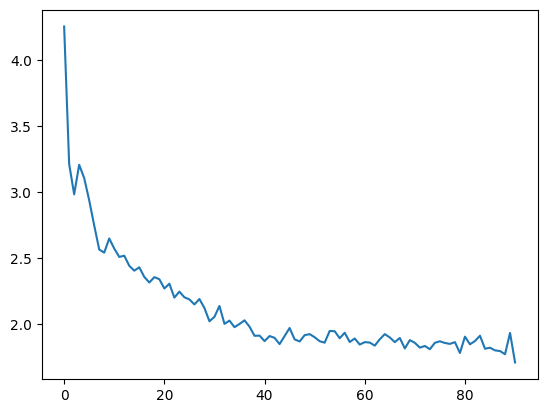

In [26]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [27]:
trainer.test(t,test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

In [ ]:
sum(acc)/len(acc)